In [ ]:
!pip install langchain-groq langchain-community chromadb

In [32]:
!pip install langchain-google-genai -U

In [1]:
import os

from dotenv import load_dotenv, find_dotenv
from langchain_groq import ChatGroq
# from langchain_google_genai import ChatGoogleGenerativeAI

from langchain_core.messages import SystemMessage
from langgraph.prebuilt import create_react_agent

In [2]:
# make sure GOOGLE_API_KEY (or any other llm provider, must exactly the same)
_ = load_dotenv(find_dotenv())
# or put it into variable and pass it to llm model 
# google_api_key = os.getenv('GOOGLE_API_KEY') # pass this to the model creation

# Agent Concept

![](../media/agent_tools.png)

What is an AI Agent? 
An AI agent is a program that uses a language model to understand a task and decide the best way to complete it using available tools autonomously.
A key idea in AI agents is the set of **Tools** (functions) they can use to get the job done. 
For each request, the AI plans the best approach, deciding what steps and tools are needed and in what order to complete the task.

For this example, we will create an Agent that could get the weather from external API, either by specify the location/city or by trying to use current location.

In [ ]:
import json
from langchain_core.documents import Document
from langchain_community.vectorstores import Chroma
from langchain_google_genai.embeddings import GoogleGenerativeAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter

with open("../data/rag/data.json", "r") as f:
  data = json.load(f)

document = []
for d in data:
  document.append(
      Document(
          page_content=d["content"],
          metadata={
              "title": d["title"],
              "url": d["url"]
          }
      )
  )

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
document_chunks = text_splitter.split_documents(document)

embedding = GoogleGenerativeAIEmbeddings(model='models/text-embedding-004', google_api_key="**")
VECTORSTORE = Chroma(persist_directory="knowledge", embedding_function=embedding, collection_metadata={"hnsw:space": "cosine"})

VECTORSTORE.add_documents(documents=document_chunks)

retriever = VECTORSTORE.as_retriever(
    search_type="similarity",
    search_kwargs={
        "k": 3
    }
)


/var/folders/h4/318cb1vj5xl_h8jj3tcyq09w0000gn/T/ipykernel_7874/989791284.py:26: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  VECTORSTORE = Chroma(persist_directory="knowledge", embedding_function=embedding, collection_metadata={"hnsw:space": "cosine"})


In [ ]:
"""
agent that we use as example:
    1. get weather
    2. get location (dummy, returning random between Jakarta, Seoul, Tokyo)
"""
import requests
from langchain_core.tools import tool
from typing import Optional
import random

# class Location(BaseModel):
#     location: str = Field(description='Location to find weather')
    
@tool
def get_weather(location: Optional[str]='Jakarta') -> str:
    """Get the weather via API in a location (provided, Jakarta as default).
    A tool designed to gather accurate information on weather around the globe. 
    Useful for when you need to answer questions about the weather. 
    Input should be the location.
    """
    WEATHERAPI_API_KEY='8a6c94f591c4401c9e8152836251301'
    res = requests.get(f'https://api.weatherapi.com/v1/current.json?key={WEATHERAPI_API_KEY}&q={location}&aqi=no')
    return "For {} temperature: {:.2F} and weather: {}".format(
        location,
        res.json()['current']['temp_c'],
        res.json()['current']['condition']['text']
        )
@tool
def get_current_location() -> str:
    """
    Get the current location of a user (approxmate).
    Input: None
    Output: City name 
    """

    random_city = ['Jakarta', 'Seoul', 'Tokyo', 'Singapore', 'Kuala Lumpur']
    return random.choice(random_city)

@tool
def search_news(question):
    """
    This tool will search for information on news based on the query.
    Input: question from user
    Output: string context
    """
    docs = retriever.invoke(question)

    context = ""
    for doc in docs:
        page_content = doc.page_content
        metadata = doc.metadata

        title = metadata['title']
        url = metadata['url']

        context += f"Title: {title}\n"
        context += f"URL: {url}\n"
        context += f"Content: {page_content}\n\n"

    return context


In [6]:
search_news.invoke("makan siang")

'Title: Program Makan Siang Gratis di Maros, Makan Pakai Wadah Plastik\nURL: https://www.kompas.com/sulawesi-selatan/read/2025/01/07/151254688/program-makan-siang-gratis-di-maros-makan-pakai-wadah-plastik\nContent: Memasuki hari kedua, proses penyaluran makan siang gratis berjalan lancar.\n\nBaca juga: Makan Siang Gratis Dipangkas, Pakar Unair: Bisa Pakai Lele hingga Nila\n\nFokus makan siang gratis di Kecamatan Mandai\n\nKetua Komite Nasional Pemuda Indonesia (KNPI) Maros ini juga menjelaskan untuk pekan ini penyaluran makan siang gratis akan difokuskan di Kecamatan Mandai.\n\n“Untuk sementara menyasar 10 sekolah, untuk wilayah pelosok belum ada juknisnya, sehingga kami masih fokus di Kecamatan Mandai,” jelasnya.\n\nSementara, Sekretaris Daerah Maros, Andi Davied Syamsuddin mengatakan pihaknya menggelontorkan dana Rp 2,5 milliar dari APBD untuk mendukung program makan siang gratis.\n\nDalam perencanaannya, anggaran tersebut diperuntukkan untuk sekolah SD di Maros.“Walau jumlahnya belu

The function is a tool already (after using decorator). In order to test the tool, call `.run()` method.

In [7]:
get_weather.invoke('Jakarta')

'For Jakarta temperature: 27.40 and weather: Partly cloudy'

In [8]:
get_current_location.invoke({})

'Singapore'

Use langgraph function to create a react agent (stands for Reasoning and Action agent). On a high level, given a query, the model will [be](https://www.leewayhertz.com/react-agents-vs-function-calling-agents/):
1. Break down the task into smaller step, choosing the required tools
2. Exceute the step based on the tools
3. Observe the result (should it use another tools or return the answer)
4. Give response


In [9]:
# llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=os.getenv('GOOGLE_API_KEY'))
llm = ChatGroq(model="gemma2-9b-it", api_key=os.getenv('GROQ_API_KEY'))
system_prompt = "You are a helpful assistant that provides information about the weather and news. Please answer in Bahasa."
query = "What's the temperature on my location?" # the agent is smart enough to call the get_location tools first, before pass it to the get_weather tools
# query = "Halo bali"
# query = "Mengapa sintayong di pecat ?"
query = "Where is my location now?"
agent_executor = create_react_agent(model=llm, tools=[get_weather, get_current_location, search_news], state_modifier=system_prompt)
message = agent_executor.invoke({
    'messages': [
        ('human', query)
    ]
})
message['messages'][-1].content

'Lokasi Anda sekarang adalah Tokyo.  '

## Saving Checkpoint

Langgraph provides a way to save a chat session by having thread_id. 

In [10]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

agent_executor = create_react_agent(model=llm, tools=[get_weather, get_current_location, search_news], state_modifier=system_prompt, checkpointer=memory)

query = "Where is my location now?"

# create configuration for Thread Id
config = {"configurable": {"thread_id": "test-thread-11"}}
message = agent_executor.invoke({
    'messages': [
        ('human', query)
    ]},
    config
)

In [11]:
message['messages'][-1]

AIMessage(content='Lokasi Anda saat ini adalah Kuala Lumpur. \n\n\n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 1304, 'total_tokens': 1316, 'completion_time': 0.021818182, 'prompt_time': 0.05861668, 'queue_time': 0.021990348, 'total_time': 0.080434862}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-d9b06249-9daa-4634-bc5e-e1722b9df28e-0', usage_metadata={'input_tokens': 1304, 'output_tokens': 12, 'total_tokens': 1316})

In [12]:
m = agent_executor.invoke({
    'messages': [
        ('human', 'Berapa suhunya ?')
    ]},
    config
)

In [13]:
m['messages'][-1]

AIMessage(content='Suhunya di Kuala Lumpur sekarang 27.10 derajat Celsius.  Hujan sedang atau deras dengan petir.  \n\n\n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 1417, 'total_tokens': 1447, 'completion_time': 0.054545455, 'prompt_time': 0.04946125, 'queue_time': 0.022069609000000004, 'total_time': 0.104006705}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-41999c33-45a1-40ca-bb33-a3fed83008e4-0', usage_metadata={'input_tokens': 1417, 'output_tokens': 30, 'total_tokens': 1447})

In [14]:
m = agent_executor.invoke({
    'messages': [
        ('human', 'Where is my location now?')
    ]},
    config
)

In [15]:
m["messages"][-1]

AIMessage(content='Lokasi Anda saat ini adalah Kuala Lumpur.  \n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 1461, 'total_tokens': 1473, 'completion_time': 0.021818182, 'prompt_time': 0.051179617, 'queue_time': 0.021286332000000005, 'total_time': 0.072997799}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-42617d7f-4399-4f8e-bc21-1624d9efb713-0', usage_metadata={'input_tokens': 1461, 'output_tokens': 12, 'total_tokens': 1473})

## Display Graph

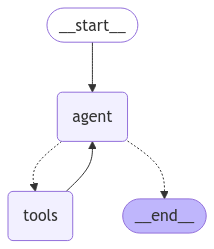

In [16]:
from IPython.display import Image, display

try:
    display(Image(agent_executor.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# From Scratch

In [17]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# Define the state
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# Modification: tell the LLM which tools it can call
tools = [get_weather, get_current_location, search_news]
llm_with_tools = llm.bind_tools(tools)

def agent(state: State):
    messages = state["messages"]
    system_prompt_message = SystemMessage(content=system_prompt)
    inputs = [system_prompt_message] + messages
    return {"messages": [llm_with_tools.invoke(inputs)]}
    # return {"messages": [llm_with_tools.invoke(messages)]}

graph_builder.add_node("agent", agent)

In [133]:
from langgraph.prebuilt import ToolNode, tools_condition
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "agent",
    tools_condition,
)

graph_builder.add_edge(START, "agent")
graph_builder.add_edge("tools", "agent")
graph_builder.set_entry_point("agent")
graph = graph_builder.compile(checkpointer=memory)


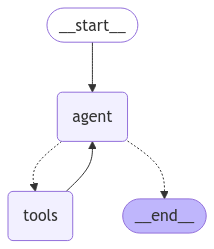

In [134]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [135]:
answer = graph.invoke(
    {
        "messages": [("human", "What's the temperature on my current location?")]
    }, 
    {"configurable": {"thread_id": 42}}
)

In [136]:
answer

{'messages': [HumanMessage(content="What's the temperature on my current location?", additional_kwargs={}, response_metadata={}, id='f9b1d286-d226-48af-91e2-86c8da57c340'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_9s4z', 'function': {'arguments': '{}', 'name': 'get_current_location'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 73, 'prompt_tokens': 1239, 'total_tokens': 1312, 'completion_time': 0.132727273, 'prompt_time': 0.053219677, 'queue_time': 0.234226955, 'total_time': 0.18594695}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e539a2c0-6cb8-44e6-9c29-bf3b3f8aca74-0', tool_calls=[{'name': 'get_current_location', 'args': {}, 'id': 'call_9s4z', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1239, 'output_tokens': 73, 'total_tokens': 1312}),
  ToolMessage(content='Seoul', name='get_current_location', id='f67d33e2-635b-44e1-969a-7bfa

In [137]:
answer["messages"][-1].content

'Suhu di Seoul saat ini 4.00 derajat Celcius dengan cuaca cerah. \n'

In [138]:
answer = graph.invoke(
    {
        "messages": [("human", "What is previous location?")]
    }, 
    {"configurable": {"thread_id": 42}}
)

In [139]:
answer

{'messages': [HumanMessage(content="What's the temperature on my current location?", additional_kwargs={}, response_metadata={}, id='f9b1d286-d226-48af-91e2-86c8da57c340'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_9s4z', 'function': {'arguments': '{}', 'name': 'get_current_location'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 73, 'prompt_tokens': 1239, 'total_tokens': 1312, 'completion_time': 0.132727273, 'prompt_time': 0.053219677, 'queue_time': 0.234226955, 'total_time': 0.18594695}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e539a2c0-6cb8-44e6-9c29-bf3b3f8aca74-0', tool_calls=[{'name': 'get_current_location', 'args': {}, 'id': 'call_9s4z', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1239, 'output_tokens': 73, 'total_tokens': 1312}),
  ToolMessage(content='Seoul', name='get_current_location', id='f67d33e2-635b-44e1-969a-7bfa